# Goal

* Run `paco` analysis on IndD dataset summed by host

# Var

In [1]:
work_dir = '/ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/'

# phyloseq
physeq_file = '/ebio/abt3_projects/Georg_animal_feces/data/16S/LLA/phyloseq/physeq_r5k.RDS'

# host phylogeny
host_tree_file = '/ebio/abt3_projects/Georg_animal_feces/data/animal/phylogeny/TT/unified_metadata_complete_20180625_rn_16S-r5k_IndD.nwk'

# misc
sparsity_cutoff = 0.05


# Init

In [2]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(stringr)
library(phyloseq)
library(ape)
library(paco)
library(future)
library(future.batchtools)
source('/ebio/abt3_projects/Georg_animal_feces/code/init.R') 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘stringr’ was built under R version 3.4.3”

In [3]:
make_dir(work_dir)
setwd(work_dir)

Directory already exists: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/ 


In [4]:
rescale_dist_mtx = function(m){
    m = m %>% as.matrix
    labs = m %>% colnames
    n_row = m %>% nrow
    n_col = m %>% ncol
    x = m %>% as.vector 
    x = scales::rescale(x) 
    m = matrix(x, nrow=n_row, ncol=n_col)
    colnames(m) = labs
    rownames(m) = labs
    m = m %>% as.dist
    return(m)
}

# Load

In [5]:
physeq = readRDS(physeq_file)
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 30290 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 30290 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 30290 tips and 29752 internal nodes ]

In [6]:
host_tree = read.tree(host_tree_file)
host_tree


Phylogenetic tree with 213 tips and 177 internal nodes.

Tip labels:
	X256.Zander, F302.Northern.Pike, X188.Brook.Trout, F300.Asp, X330.Ide, X327.Silver.Bream, ...
Node labels:
	, @_22_@, @_8_@, @_7_@, @_20_@, @_17_@, ...

Rooted; includes branch lengths.

# Filtering dataset

## OTU table

In [7]:
physeq %>%
    otu_table %>% 
    colSums %>%
    summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5000    5000    5000    5000    5000    5000 

In [8]:
physeq = physeq %>%
    filter_taxa(function(x) sum(x > 0) / length(x) > sparsity_cutoff, TRUE) 
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 408 taxa and 213 samples ]
sample_data() Sample Data:       [ 213 samples by 171 sample variables ]
tax_table()   Taxonomy Table:    [ 408 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 408 tips and 406 internal nodes ]

In [9]:
metadata = physeq %>%
    sample_data %>%
    dplyr::select(X.SampleID, scientific_name) %>%
    rename('SampleID' = X.SampleID) %>%
    as.data.frame

rownames(metadata) = metadata$SampleID
#metadata$sample = NULL

metadata %>% status

[1] 213   2


,SampleID,scientific_name
X1.Eurasian.Beaver,X1.Eurasian.Beaver,Castor_fiber
X101.Horse,X101.Horse,Equus_caballus
X102.Kulan,X102.Kulan,Equus_hemionus


# 16S dist mtx

In [10]:
micro_D = physeq %>% phy_tree %>% cophenetic %>% rescale_dist_mtx %>% as.matrix
micro_D %>% dim

[1] 408 408

In [11]:
print(micro_D %>% dim)

[1] 408 408


# Host dist mtx

In [12]:
host_D = host_tree %>% cophenetic %>% rescale_dist_mtx %>% as.matrix
host_D %>% dim

[1] 213 213

In [13]:
setdiff(rownames(host_D), metadata$SampleID) %>% print
setdiff(metadata$SampleID, rownames(host_D)) %>% print

character(0)
character(0)


In [14]:
host_D = host_D[metadata$SampleID, metadata$SampleID] 
host_D %>% status

[1] 213 213


,X294.Emu,X33.Wild.Turkey,X131.Rock.Ptarmigan,X31.Chicken,X276.Barnacle.Goose,X32.Greylag.Goose,X34.Mallard.Duck,X117.Long.eared.Owl,X426.Ural.Owl,X260.Blackbird,⋯,X36.Agile.Frog,F157a.European.Toad,F157b.European.Toad,X342.European.Green.Toad,X233.Aesculapian.Snake,X351.Grass.Snake,X95.Meadow.Viper,X44.Meadow.Viper,X241.Italian.wall.lizard,X190.Common.House.Gecko
X294.Emu,0.0000000,0.25579478,0.25579478,0.25579478,0.2557948,0.2557948,0.2557948,0.2557948,0.2557948,0.2557948,⋯,0.8080382,0.8080382,0.8080382,0.8080382,0.642411,0.642411,0.642411,0.642411,0.642411,0.642411
X33.Wild.Turkey,0.2557948,0.00000000,0.04762221,0.08545358,0.1836687,0.1836687,0.1836687,0.2252181,0.2252181,0.2252181,⋯,0.8080382,0.8080382,0.8080382,0.8080382,0.642411,0.642411,0.642411,0.642411,0.642411,0.642411
X131.Rock.Ptarmigan,0.2557948,0.04762221,0.00000000,0.08545358,0.1836687,0.1836687,0.1836687,0.2252181,0.2252181,0.2252181,⋯,0.8080382,0.8080382,0.8080382,0.8080382,0.642411,0.642411,0.642411,0.642411,0.642411,0.642411


# Comparing distributions

In [15]:
host_D %>% as.vector %>% summary %>% print
micro_D %>% as.vector %>% summary %>% print

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2063  0.2423  0.4448  0.7165  1.0000 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.2077  0.2850  0.3160  0.3730  1.0000 


# PACO: constrained model

## Preparing data

In [16]:
metadata %>% status

[1] 213   2


,SampleID,scientific_name
X1.Eurasian.Beaver,X1.Eurasian.Beaver,Castor_fiber
X101.Horse,X101.Horse,Equus_caballus
X102.Kulan,X102.Kulan,Equus_hemionus


In [17]:
# otu abundance matrix
otu = physeq %>% 
    otu_table %>%
    as.data.frame %>%
    as.matrix %>%
    t

# convert to binary
otu = otu %>% apply(2, function(x) ifelse(x > 0, 1, 0)) %>% as.matrix
                    
# changing rownames
rownames(otu) = metadata[unique(rownames(otu)),]$SampleID
                    
# status                    
otu %>% status

[1] 213 408


,368bd5c2255f3a5ce0fef06ca6de1d04,779324e5648460c5a67e577c45131b42,b918d185ee89a0b33d821ee766d76eb3,d3d51a026150fca2a3400c59a6b311cb,160c9184bbfc1e5766c508c7bdafa19f,f0f035365a85490145f397bf218afbab,7282e9b6f799208576024a35f02caa47,0e1de44ae4fcc0968e549457277b4fb1,ba6caaf355af10bdcdcc625e4f99073e,13fabb2c42c260bd77b4358f429eba6c,⋯,1b4755614ecbdd82a79e77eae5143239,d855008e1da5c9a5c3ba81d21b6ea272,9dfddc1c446e84f8ff7f5a7332e70e3a,6f8aa3da4c4fa50cd74ad28f489adefc,22930923dace53039f5eb90d94ceca1e,88f04219eab15eae30870064288e9a5f,17dac3c523ec0b232c6a9c711d69968f,98300b47154d82766e5d100558d1ba09,958c1eeaa690e27ee970154111e25192,d78e13cf379c4409b2bc382ffb62f962
X1.Eurasian.Beaver,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X101.Horse,0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
X102.Kulan,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [18]:
setdiff(rownames(otu), rownames(metadata))
setdiff(rownames(metadata), rownames(otu))

character(0)

character(0)

In [19]:
setdiff(rownames(otu), rownames(host_D)) %>% sort %>% print
setdiff(rownames(host_D), rownames(otu)) %>% sort %>% print

character(0)
character(0)


In [20]:
D = prepare_paco_data(H=host_D, P=micro_D, HP=otu)
D %>% names

[1] "H"  "P"  "HP"

In [21]:
D = add_pcoord(D, correction='cailliez')
D %>% names

[1] "H"          "P"          "HP"         "H_PCo"      "P_PCo"     
[6] "correction"

In [22]:
D$H_PCo %>% as.vector %>% summary %>% print
D$P_PCo %>% as.vector %>% summary %>% print

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.5500208 -0.0000002  0.0000000 -0.0013228  0.0000001  0.7638120 
      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.6117609 -0.0000672  0.0000000  0.0000399  0.0000504  0.2816034 


In [23]:
neg_to_pos_eig = function(PCo){
    min_val = PCo %>% as.vector %>% min
    print(min_val)
    if(min_val < 0){
        PCo = PCo + abs(min_val)
    }
    return(PCo)
}

D$H_PCo = neg_to_pos_eig(D$H_PCo)
D$P_PCo = neg_to_pos_eig(D$P_PCo)

# status
D$H_PCo %>% as.vector %>% summary %>% print
D$P_PCo %>% as.vector %>% summary %>% print

[1] -0.5500208
[1] -0.6117609
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.5500  0.5500  0.5487  0.5500  1.3138 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.6117  0.6118  0.6118  0.6118  0.8934 


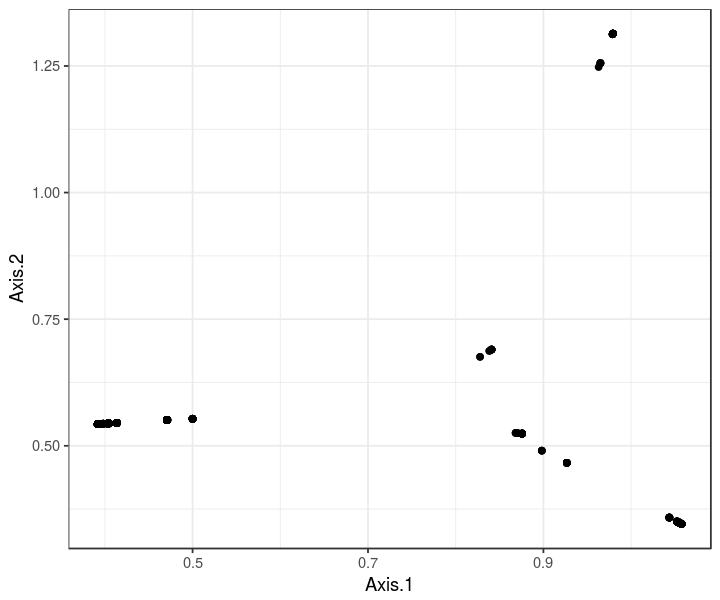

In [24]:
tmp = D$H_PCo[,c('Axis.1', 'Axis.2')] %>% as.data.frame
p_host = ggplot(tmp, aes(Axis.1, Axis.2)) +
    geom_point() +
    theme_bw()

options(repr.plot.height=5, repr.plot.width=6)
plot(p_host)

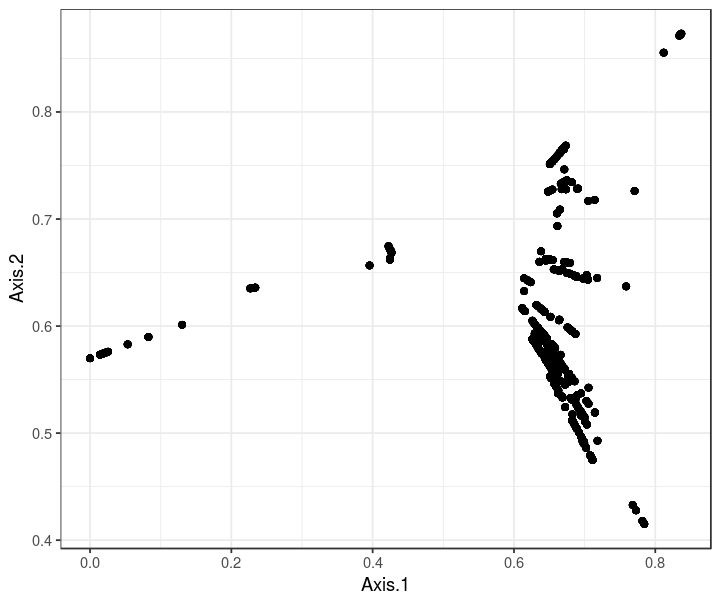

In [25]:
tmp = D$P_PCo[,c('Axis.1', 'Axis.2')] %>% as.data.frame
p_micro = ggplot(tmp, aes(Axis.1, Axis.2)) +
    geom_point() +
    theme_bw()
plot(p_micro)

## PACo

In [26]:
# for loading results instead of re-running
PACo_file = file.path(work_dir, 'physeq_IndD_PACo.RDS')

In [27]:
# cluster resources
resources = list(h_rt = '36:00:00',
                 h_vmem = '12G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3/bin")
plan(batchtools_sge, resources=resources)

In [28]:
#-- WARNING: SLOW --#
# r0 method => the assumption that the column group tracks the evolution of the row group; therefore, maintaining the degree of the species in the row group
D %<-% { PACo(D, nperm=999, seed=39473, method='r0', symmetric=FALSE) } %packages% c("paco")

In [29]:
# save results
saveRDS(D, PACo_file)
cat('File written:', PACo_file, '\n')

File written: /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT//physeq_IndD_PACo.RDS 


In [30]:
# load results
D = readRDS(PACo_file)

In [35]:
#send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/paco/host_TT/5_paco_IndD.ipynb')

In [32]:
# goodness of fit
D$gof

$p
[1] 0

$ss
[1] 262.4917

$n
[1] 999

In [33]:
D$proc$X %>% dim %>% print
D$proc$Y %>% dim %>% print

[1] 6077  245
[1] 6077  245


### Proc plot

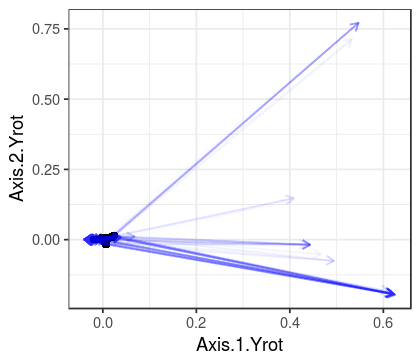

In [34]:
# x points
x = D$proc$X %>% as.data.frame
x$lab = rownames(x)
rownames(x) = 1:nrow(x)
x$type = 'X'
colnames(x)[1:2] = c('Axis.1', 'Axis.2')

# yrot points
y = D$proc$Yrot %>% as.data.frame
y$lab = rownames(y)
rownames(y) = 1:nrow(y)
y$type = 'Yrot'
colnames(y)[1:2] = c('Axis.1', 'Axis.2')

# df for plotting arrows
cols = c('Axis.1', 'Axis.2', 'type')
df = cbind(x[,cols],y[,cols]) 
colnames(df) = c('Axis.1.X', 'Axis.2.X', 'type.X',
                       'Axis.1.Yrot', 'Axis.2.Yrot', 'type.Yrot')

# plotting
p = ggplot(df, aes(Axis.1.Yrot, Axis.2.Yrot)) +
    geom_point(shape='O') +
    geom_segment(color='blue', alpha=0.01,
                 aes(x=Axis.1.Yrot, y=Axis.2.Yrot, xend=Axis.1.X, yend=Axis.2.X),
                 arrow = arrow(length = unit(0.03, "npc"))) +
    theme_bw()

options(repr.plot.height=3, repr.plot.width=3.5)
plot(p)

## Individual contributions

In [36]:
# for loading results instead of re-running
PACo_links_file = file.path(work_dir, 'physeq_IndD_PACo-links.RDS')

In [37]:
# cluster resources
resources = list(threads = 12,
                 h_rt = '36:00:00',
                 h_vmem = '12G',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3/bin")
plan(batchtools_sge, resources=resources)

In [38]:
# wrapper
paco_links_run = function(D, threads=1){
    doParallel::registerDoParallel(cores=threads)
    paco::paco_links(D, .parallel=TRUE)
}

In [39]:
#-- WARNING: SLOW --#
D_links %<-% { paco_links_run(D, threads) } %packages% c("paco", "doParallel")

In [40]:
# saving object
saveRDS(D_links, PACo_links_file)
cat('File written:', PACo_links_file, '\n')

ERROR: Error: BatchtoolsExpiration: Future ('<none>') expired (registry path /ebio/abt3_projects/Georg_animal_feces/data/host_specific/pcao/host_TT/.future/20180710_160015-F5O9rg/batchtools_2015353414).. The last few lines of the logged output:
Warning in vegan::procrustes(X = PACo.ind$H_PCo, Y = PACo.ind$P_PCo) :
  X has fewer axes than Y: X adjusted to comform Y
Warning in vegan::procrustes(X = PACo.ind$H_PCo, Y = PACo.ind$P_PCo) :
  X has fewer axes than Y: X adjusted to comform Y
Warning in vegan::procrustes(X = PACo.ind$H_PCo, Y = PACo.ind$P_PCo) :
  X has fewer axes than Y: X adjusted to comform Y


In [ ]:
# loading object
D_links = readRDS(PACo_links_file)

In [ ]:
# residuals
res = residuals_paco(D_links$proc) %>% as.data.frame 
colnames(res) = 'residuals'
res = res %>%
    mutate(comparison = rownames(.)) %>%
    separate(comparison, c('host', 'microbe'), sep='-') 
res %>% status

In [ ]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/paco/host_TT/5_paco_IndD.ipynb')

# -- first email here --

### Formatting output

In [ ]:
D_links_jk = do.call(rbind, D_links$jackknife) %>%
    t %>% as.data.frame %>%
    mutate(comparison = rownames(.)) %>%
    separate(comparison, c('host', 'microbe'), sep='-') %>%
    inner_join(res, c('host'='host', 'microbe'='microbe'))

D_links_jk %>% status

In [ ]:
# adding taxonomy
tax = physeq %>% tax_table %>% 
    as.matrix %>% as.data.frame %>%
    mutate(microbe = rownames(.))

D_links_jk = D_links_jk %>%
    inner_join(tax, c('microbe'))

D_links_jk %>% status

### Summarizing results

In [ ]:
# value distribution
tmp = D_links_jk %>%
    unite(compare, host, microbe) %>%
    mutate(mean = mean %>% as.character %>% as.numeric,
           upper = upper %>% as.character %>% as.numeric, 
           lower = mean - (upper - mean),
           compare = compare %>% reorder(-mean))

p = ggplot(tmp, aes(compare, mean)) +
    geom_linerange(aes(ymin=lower, ymax=upper), alpha=0.3) +
    geom_point(size=1.5) +
    theme_bw() +
    theme(
        axis.text.x = element_blank()
    )
    
options(repr.plot.width=8, repr.plot.height=4)
plot(p)

In [ ]:
# value distribution
p = ggplot(D_links_jk, aes(residuals)) +
    geom_histogram(bins=70) +
    theme_bw() 
    
options(repr.plot.width=6, repr.plot.height=3)
plot(p)

# PACO: diffused model

In [ ]:
# for loading results instead of re-running
PACo_file = file.path(work_dir, 'physeq_IndD_PACo-Con.RDS')

In [ ]:
# cluster resources
resources = list(h_rt = '36:00:00',
                 h_vmem = '10G',
                 threads = '1',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3/bin")
plan(batchtools_sge, resources=resources)

In [ ]:
#-- WARNING: SLOW --#
D %<-% { PACo(D, nperm=1000, seed=3874, method='quasiswap', symmetric=TRUE) } %packages% c("paco")

In [ ]:
# save results
saveRDS(D, PACo_file)
cat('File written:', PACo_file, '\n')

In [ ]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/paco/host_TT/5_paco_IndD.ipynb')

In [ ]:
# load results
D = readRDS(PACo_file)

In [ ]:
# goodness of fit
D$gof

# -- TO HERE -- (see above)

### Proc plot

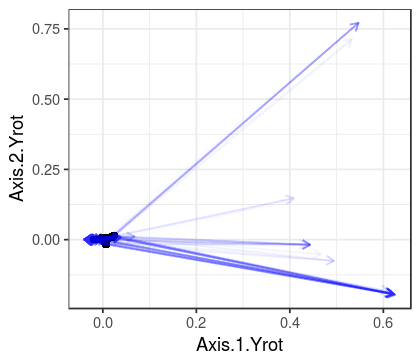

In [41]:
# x points
x = D$proc$X %>% as.data.frame
x$lab = rownames(x)
rownames(x) = 1:nrow(x)
x$type = 'X'
colnames(x)[1:2] = c('Axis.1', 'Axis.2')

# yrot points
y = D$proc$Yrot %>% as.data.frame
y$lab = rownames(y)
rownames(y) = 1:nrow(y)
y$type = 'Yrot'
colnames(y)[1:2] = c('Axis.1', 'Axis.2')

# df for plotting arrows
cols = c('Axis.1', 'Axis.2', 'type')
df = cbind(x[,cols],y[,cols]) 
colnames(df) = c('Axis.1.X', 'Axis.2.X', 'type.X',
                       'Axis.1.Yrot', 'Axis.2.Yrot', 'type.Yrot')

p = ggplot(df, aes(Axis.1.Yrot, Axis.2.Yrot)) +
    geom_point(shape='O') +
    geom_segment(color='blue', alpha=0.01,
                 aes(x=Axis.1.Yrot, y=Axis.2.Yrot, xend=Axis.1.X, yend=Axis.2.X),
                 arrow = arrow(length = unit(0.03, "npc"))) +
    theme_bw()

options(repr.plot.height=3, repr.plot.width=3.5)
plot(p)

## Individual contributions

In [42]:
# for loading results instead of re-running
PACo_links_file = file.path(work_dir, 'physeq_IndD_PACo-Con-links.RDS')

In [43]:
# cluster resources
resources = list(threads = 12,
                 h_rt = '36:00:00',
                 h_vmem = '10G',
                 conda.env = 'py3_physeq_phylo', 
                 conda.path = "/ebio/abt3_projects/software/miniconda3/bin")
plan(batchtools_sge, resources=resources)

In [44]:
#-- WARNING: SLOW --#

# wrapper
paco_links_run = function(D, threads=1){
    doParallel::registerDoParallel(cores=threads)
    paco::paco_links(D, .parallel=TRUE)
}

# run on cluster
D_links %<-% { paco_links_run(D, threads) } %packages% c("paco", "doParallel")

In [ ]:
# saving object
saveRDS(D_links, PACo_links_file)
cat('File written:', PACo_links_file, '\n')

In [ ]:
# loading object
D_links = readRDS(PACo_links_file)

In [ ]:
# residuals
res = residuals_paco(D_links$proc) %>% as.data.frame 
colnames(res) = 'residuals'
res = res %>%
    mutate(comparison = rownames(.)) %>%
    separate(comparison, c('host', 'microbe'), sep='-') 
res %>% status

In [ ]:
res$microbe %>% unique %>% length

In [ ]:
send_email('http://127.0.0.1:9705/notebooks/notebooks/16S/4_host_specific/paco/host_TT/5_paco_IndD.ipynb')

# -- TO HERE --

### Formatting output

In [ ]:
D_links_jk = do.call(rbind, D_links$jackknife) %>%
    t %>% as.data.frame %>%
    mutate(comparison = rownames(.)) %>%
    separate(comparison, c('host', 'microbe'), sep='-') %>%
    inner_join(res, c('host'='host', 'microbe'='microbe'))

D_links_jk %>% status

In [ ]:
# adding taxonomy
tax = physeq %>% tax_table %>% 
    as.matrix %>% as.data.frame %>%
    mutate(microbe = rownames(.))

D_links_jk = D_links_jk %>%
    inner_join(tax, c('microbe'))

D_links_jk %>% status

### Summarizing results

In [ ]:
# value distribution
tmp = D_links_jk %>%
    unite(compare, host, microbe) %>%
    mutate(mean = mean %>% as.character %>% as.numeric,
           upper = upper %>% as.character %>% as.numeric, 
           lower = mean - (upper - mean),
           compare = compare %>% reorder(-mean))

p = ggplot(tmp, aes(compare, mean)) +
    geom_linerange(aes(ymin=lower, ymax=upper), alpha=0.3) +
    geom_point(size=0.5) +
    theme_bw() +
    theme(
        axis.text.x = element_blank()
    )
    
options(repr.plot.width=8, repr.plot.height=2.5)
plot_write(p)

In [ ]:
# value distribution
p = ggplot(D_links_jk, aes(residuals)) +
    geom_histogram(bins=70) +
    theme_bw() 
    
options(repr.plot.width=6, repr.plot.height=3)
plot_write(p)

In [ ]:
# summarizing by taxonomy
tmp = D_links_jk %>%
    filter(!is.na(residuals),
           Genus != '', 
           Genus != 'uncultured',
           Genus != 'unclassified') %>%
    group_by(Genus) %>%
    mutate(mean_res = mean(residuals, na.rm=TRUE),
           n = n() %>% as.numeric) %>%
    ungroup() %>%
    mutate(Genus = Genus %>% reorder(mean_res),
           Genus = Genus %>% reorder(Phylum %>% as.factor %>% as.numeric))

p = ggplot(tmp, aes(Genus, residuals, color=Phylum)) +
    geom_boxplot() +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5)
    )

options(repr.plot.width=10, repr.plot.height=4)
plot_write(p)

In [ ]:
p = ggplot(tmp, aes(Genus, n, fill=Phylum)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5)
    )

options(repr.plot.width=10, repr.plot.height=4)
plot_write(p)

In [ ]:
tmp %>% 
    filter(Genus == 'Christensenella') 

### Writing table

In [ ]:
res_file = file.path(work_dir, 'physeq_IndD_PACo-Con-links.txt')
write.table(D_links_jk, file=res_file, sep='\t', quote=FALSE, row.names=FALSE)
cat('File written:', res_file, '\n')

### Formatting for iTOL

* Plotting residuals onto host tree

In [ ]:
D_links_jk %>% status

In [ ]:
otu_m = D_links_jk %>%
    mutate(microbe = microbe %>% as.factor %>% as.numeric,
           microbe = gsub('^', 'SV', microbe)) %>%
    unite(OTU, Genus, microbe) %>%
    filter(!grepl('^_SV', OTU)) %>%
    #mutate(host = gsub('^[A-Z][0-9]+b*\\.', '', host),
    #       host = gsub(' ', '_', host)) %>%
    dplyr::select(host, OTU, residuals) %>%
    spread(OTU, residuals) 

rownames(otu_m) = otu_m$host 
otu_m$host = NULL

otu_m %>% status

In [ ]:
# checking overlap with host clado tips
host_tree = read.tree(host_tree_file)
setdiff(host_tree$tip.label, rownames(otu_m)) %>% print
setdiff(rownames(otu_m), host_tree$tip.label) %>% print

In [ ]:
itol_htmp_file = file.path(work_dir, 'physeq_IndD_PACo-Con-links_htmp.txt')
labs = gsub(' ', '_', colnames(otu_m))
labs = sprintf('FIELD_LABELS %s\n', paste(labs, collapse=' '))

cat('DATASET_HEATMAP\n', file=itol_htmp_file)
cat('SEPARATOR SPACE\n', file=itol_htmp_file, append=TRUE)
cat('DATASET_LABEL paco_residuals\n', file=itol_htmp_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_htmp_file, append=TRUE)
cat(labs, file=itol_htmp_file, append=TRUE)
cat('DATA\n', file=itol_htmp_file, append=TRUE)
write.table(otu_m, file=itol_htmp_file, append=TRUE, sep=' ', 
            quote=FALSE, col.names=FALSE)
cat('File written:', itol_htmp_file, '\n')

### iTOL: distribution of residuals per host species

In [ ]:
# summing residuals by host
#ID1,minimum,q1,median,q3,maximum,extreme_value1,extreme_value2
tmp = D_links_jk %>%
    filter(!is.na(residuals)) %>%
    #mutate(host = gsub('^[A-Z][0-9]+b*\\.', '', host),
    #       host = gsub(' ', '_', host)) %>%
    group_by(host) %>%
    summarize(minimum = min(residuals),
              q1 = quantile(residuals, 0.25),
              median = median(residuals),
              q3 = quantile(residuals, 0.75),
              maximum = max(residuals)) %>%
    ungroup() 


tmp %>% status

In [ ]:
itol_box_file = file.path(work_dir, 'physeq_IndD_PACo-Con-links_box.txt')

cat('DATASET_BOXPLOT\n', file=itol_box_file)
cat('SEPARATOR SPACE\n', file=itol_box_file, append=TRUE)
cat('DATASET_LABEL residuals_boxplot\n', file=itol_box_file, append=TRUE)
cat('COLOR #ff0000\n', file=itol_box_file, append=TRUE)
cat('DATA\n', file=itol_box_file, append=TRUE)
write.table(tmp, file=itol_box_file, append=TRUE, sep=' ', 
            quote=FALSE, row.names=FALSE, col.names=FALSE)
cat('File written:', itol_box_file, '\n')

# sessionInfo

In [ ]:
sessionInfo()

***